In [1]:
import os
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import PIL
import pickle
import sys

import warnings
warnings.filterwarnings("ignore")

2024-05-28 17:33:43.876749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-05-28 17:33:44.770383: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.4/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.4/lib64:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2024-05-28 17:33:44.770525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.4/lib64:/usr/local/cuda/lib64:/usr/local/cuda-

In [2]:
# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# One-hot encode function
def one_hot_encode(labels, num_classes):
    return F.one_hot(labels, num_classes=num_classes)

# Define the custom collate function
def collate(batch):
    images, labels = zip(*batch)

    encoding = feature_extractor(images=list(images), return_tensors="pt", do_rescale=False)
    pixel_values = encoding["pixel_values"]
    labels = torch.tensor(labels)
    return pixel_values, labels

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
])

# Define data transformations for validation and testing (no augmentation)
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the datasets with appropriate transformations
train_dataset = datasets.ImageFolder(root='./train', transform=train_transform)
valid_dataset = datasets.ImageFolder(root='./valid', transform=eval_transform)
test_dataset = datasets.ImageFolder(root='./test', transform=eval_transform)

# Select a subset of the training data for testing porpuses
# subset_indices = np.random.choice(len(train_dataset), int(len(train_dataset) * 0.01), replace=False)  # for example, 10% of the data
# subset_train_dataset = Subset(train_dataset, subset_indices)

# Create DataLoader instances with the custom collate function
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate)

for images, labels in DataLoader(train_dataset, batch_size=1, collate_fn=collate):
    print(images.shape, labels.shape)
    break

torch.Size([1, 3, 224, 224]) torch.Size([1])


In [3]:
num_classes = len(train_dataset.classes)  # Automatically determine the number of classes

# Update the classifier to match the number of classes
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.config.num_labels = num_classes

# Check if GPU is available and move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [4]:
model_id = "final_full_model"
os.mkdir(f"./ViT_saves/{model_id}")

results = {}

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

ending_epochs = 50
starting_epoch = 0

# Add an early stopping mechanism
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(starting_epoch, ending_epochs, 1):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    # Wrap your data loader with tqdm for a progress bar
    # progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{ending_epochs}')
    # for batch_idx, (pixel_values, labels) in progress_bar:
    for batch_idx, (pixel_values, labels) in enumerate(train_loader):
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(pixel_values)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(logits, 1)
        num_corrects = torch.sum(preds == labels.data)
        running_corrects += num_corrects
        total_samples += labels.size(0)

        running_loss += loss.item()
        batch_accuracy = num_corrects.double() / labels.size(0)
        running_accuracy = running_corrects / total_samples

        # Update the progress bar with loss and accuracy
        # progress_bar.set_postfix({'Running Loss': f'{running_loss/(batch_idx+1):.4f}', 'Running Accuracy': f'{running_accuracy:.4f}'})
    
    
    model_save_path = f'./ViT_saves/{model_id}/model_epoch_{epoch+1}.pt'
    torch.save(model.state_dict(), model_save_path)

    # Validation phase
    model.eval()
    val_loss = 0
    val_running_corrects = 0
    val_total_samples = 0
    
    with torch.no_grad():
        for val_pixel_values, val_labels in valid_loader:
            val_pixel_values = val_pixel_values.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = model(val_pixel_values)


            val_logits = val_outputs.logits
            val_loss = criterion(val_logits, val_labels)
            _, val_preds = torch.max(val_logits, 1)
            val_running_corrects += torch.sum(val_preds == val_labels.data)
            val_total_samples += val_labels.size(0)

    val_accuracy = val_running_corrects.double() / val_total_samples
    print(f'Epoch {epoch+1}/{ending_epochs} done:', 'Running Loss: ', f'{running_loss/(batch_idx+1):.4f}', 'Running Accuracy: ', f'{running_accuracy:.4f}', f'Validation Loss: {val_loss.item():.4f}', f'Validation Accuracy: {val_accuracy:.4f}')

    scheduler.step(val_loss)
    

    results[epoch+1] = [val_accuracy.item() , running_corrects.item() / total_samples, val_loss.item(), running_loss/(batch_idx+1)]
    
    # Save the data to a file
    with open(f'./ViT_saves/{model_id}/results.pickle', 'wb') as file:
        pickle.dump(results, file)

    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Finished due to early stopping")
        break

Epoch 1/50 done: Running Loss:  0.8962 Running Accuracy:  0.8609 Validation Loss: 2.6030 Validation Accuracy: 0.9710


Epoch 2/50 done: Running Loss:  0.1816 Running Accuracy:  0.9556 Validation Loss: 0.3213 Validation Accuracy: 0.9710


Epoch 3/50 done: Running Loss:  0.1303 Running Accuracy:  0.9654 Validation Loss: 0.9900 Validation Accuracy: 0.9726


Epoch 4/50 done: Running Loss:  0.1034 Running Accuracy:  0.9712 Validation Loss: 1.6645 Validation Accuracy: 0.9695


Epoch 5/50 done: Running Loss:  0.0907 Running Accuracy:  0.9744 Validation Loss: 4.3495 Validation Accuracy: 0.9726


Epoch 6/50 done: Running Loss:  0.0815 Running Accuracy:  0.9765 Validation Loss: 0.2477 Validation Accuracy: 0.9676


Epoch 7/50 done: Running Loss:  0.0740 Running Accuracy:  0.9786 Validation Loss: 0.0203 Validation Accuracy: 0.9707


Epoch 8/50 done: Running Loss:  0.0652 Running Accuracy:  0.9809 Validation Loss: 0.5273 Validation Accuracy: 0.9695


Epoch 9/50 done: Running Loss:  0.0660 Running Accuracy:  0.9808 Validation Loss: 1.7864 Validation Accuracy: 0.9699


Epoch 10/50 done: Running Loss:  0.0600 Running Accuracy:  0.9826 Validation Loss: 1.6545 Validation Accuracy: 0.9646


Epoch 11/50 done: Running Loss:  0.0588 Running Accuracy:  0.9827 Validation Loss: 0.9877 Validation Accuracy: 0.9726
Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.


Epoch 12/50 done: Running Loss:  0.0206 Running Accuracy:  0.9940 Validation Loss: 1.7919 Validation Accuracy: 0.9817


Epoch 13/50 done: Running Loss:  0.0100 Running Accuracy:  0.9970 Validation Loss: 2.6302 Validation Accuracy: 0.9821


Epoch 14/50 done: Running Loss:  0.0076 Running Accuracy:  0.9976 Validation Loss: 1.2605 Validation Accuracy: 0.9848


Epoch 15/50 done: Running Loss:  0.0067 Running Accuracy:  0.9979 Validation Loss: 0.5986 Validation Accuracy: 0.9848
Epoch 00015: reducing learning rate of group 0 to 1.0000e-06.


Epoch 16/50 done: Running Loss:  0.0052 Running Accuracy:  0.9986 Validation Loss: 0.9079 Validation Accuracy: 0.9848


Epoch 17/50 done: Running Loss:  0.0045 Running Accuracy:  0.9985 Validation Loss: 1.0045 Validation Accuracy: 0.9855
Finished due to early stopping


In [5]:
# Load the data back from the file
with open(f'./ViT_saves/{model_id}/results.pickle', 'rb') as file:
    results = pickle.load(file)

In [6]:
#Load the model with the highest validation accuracy
best_epoch = max(results, key=lambda k: results[k][0])
print("Best Epoch: ", best_epoch)

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.config.num_labels = num_classes
model_path = f'./ViT_saves/{model_id}/model_epoch_{best_epoch}.pt'
model.load_state_dict(torch.load(model_path))

# Check if GPU is available and move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Best Epoch:  17


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

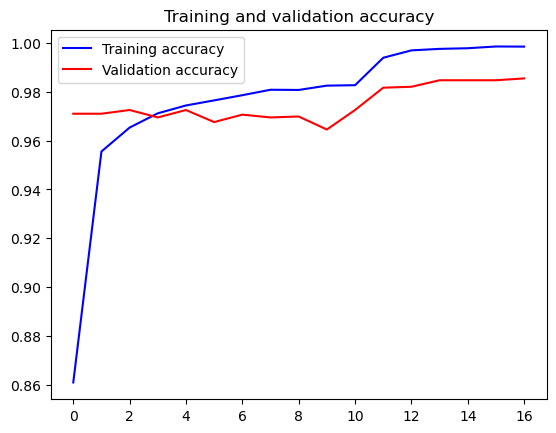

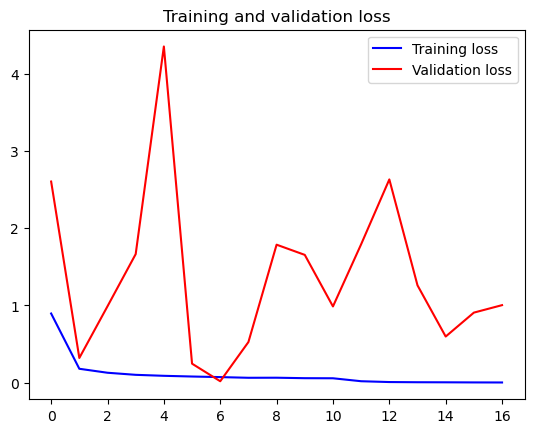

In [7]:
epochs = list(results.keys())
val_accuracy = [result[0] for result in results.values()]
accuracy = [result[1] for result in results.values()]
val_loss = [result[2] for result in results.values()]
loss = [result[3] for result in results.values()]


epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [8]:
model.eval()  # Set the model to evaluation mode
test_running_corrects = 0
total_test_samples = 0

with torch.no_grad():  # No gradients needed
    for pixel_values, labels in test_loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values)
        logits = outputs.logits
        _, preds = torch.max(logits, 1)

        test_running_corrects += torch.sum(preds == labels.data)
        total_test_samples += labels.size(0)

test_accuracy = test_running_corrects.double() / total_test_samples
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9916


In [9]:
# Set the model to evaluation mode
model.eval()

# Dictionaries to store correct predictions and total samples per class
class_correct = dict()
class_total = dict()
incorrect_samples = []

# Initialize dictionaries
for class_index, class_name in enumerate(test_loader.dataset.classes):
    class_correct[class_name] = 0
    class_total[class_name] = 0

with torch.no_grad():  # No gradients needed
    for pixel_values, labels in test_loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values)
        logits = outputs.logits
        _, preds = torch.max(logits, 1)

        # Compare predictions with the true labels
        correct_tensor = preds.eq(labels.data.view_as(preds))
        
        # Iterate over correct tensor and count correct predictions
        for i in range(len(labels)):
            label = labels.data[i]
            class_name = test_loader.dataset.classes[label]
            class_correct[class_name] += correct_tensor[i].item()
            class_total[class_name] += 1
            if not correct_tensor[i].item():
                incorrect_samples.append((pixel_values[i], label, preds[i].item()))

# Calculate and print accuracy for each class
for class_name in class_correct:
    accuracy = 100 * float(class_correct[class_name]) / class_total[class_name]
    if accuracy != 100:
        print(f'Accuracy of {class_name} : {accuracy:.2f}%')

print("Total number of incorrectly classified birds in the test dataset: ", len(incorrect_samples))

Accuracy of ANDEAN GOOSE : 80.00%
Accuracy of AUSTRAL CANASTERO : 60.00%
Accuracy of BALTIMORE ORIOLE : 80.00%
Accuracy of BLACK NECKED STILT : 80.00%
Accuracy of BLUE GRAY GNATCATCHER : 80.00%
Accuracy of CANVASBACK : 80.00%
Accuracy of CERULEAN WARBLER : 80.00%
Accuracy of CRESTED SERPENT EAGLE : 80.00%
Accuracy of DOUBLE BRESTED CORMARANT : 80.00%
Accuracy of EASTERN GOLDEN WEAVER : 80.00%
Accuracy of GRAY PARTRIDGE : 40.00%
Accuracy of HAMERKOP : 80.00%
Accuracy of MALACHITE KINGFISHER : 80.00%
Accuracy of MCKAYS BUNTING : 80.00%
Accuracy of ORANGE BREASTED TROGON : 80.00%
Accuracy of PUNA TEAL : 80.00%
Accuracy of RUBY THROATED HUMMINGBIRD : 80.00%
Accuracy of SAYS PHOEBE : 80.00%
Accuracy of WILLOW PTARMIGAN : 80.00%
Total number of incorrectly classified birds in the test dataset:  22


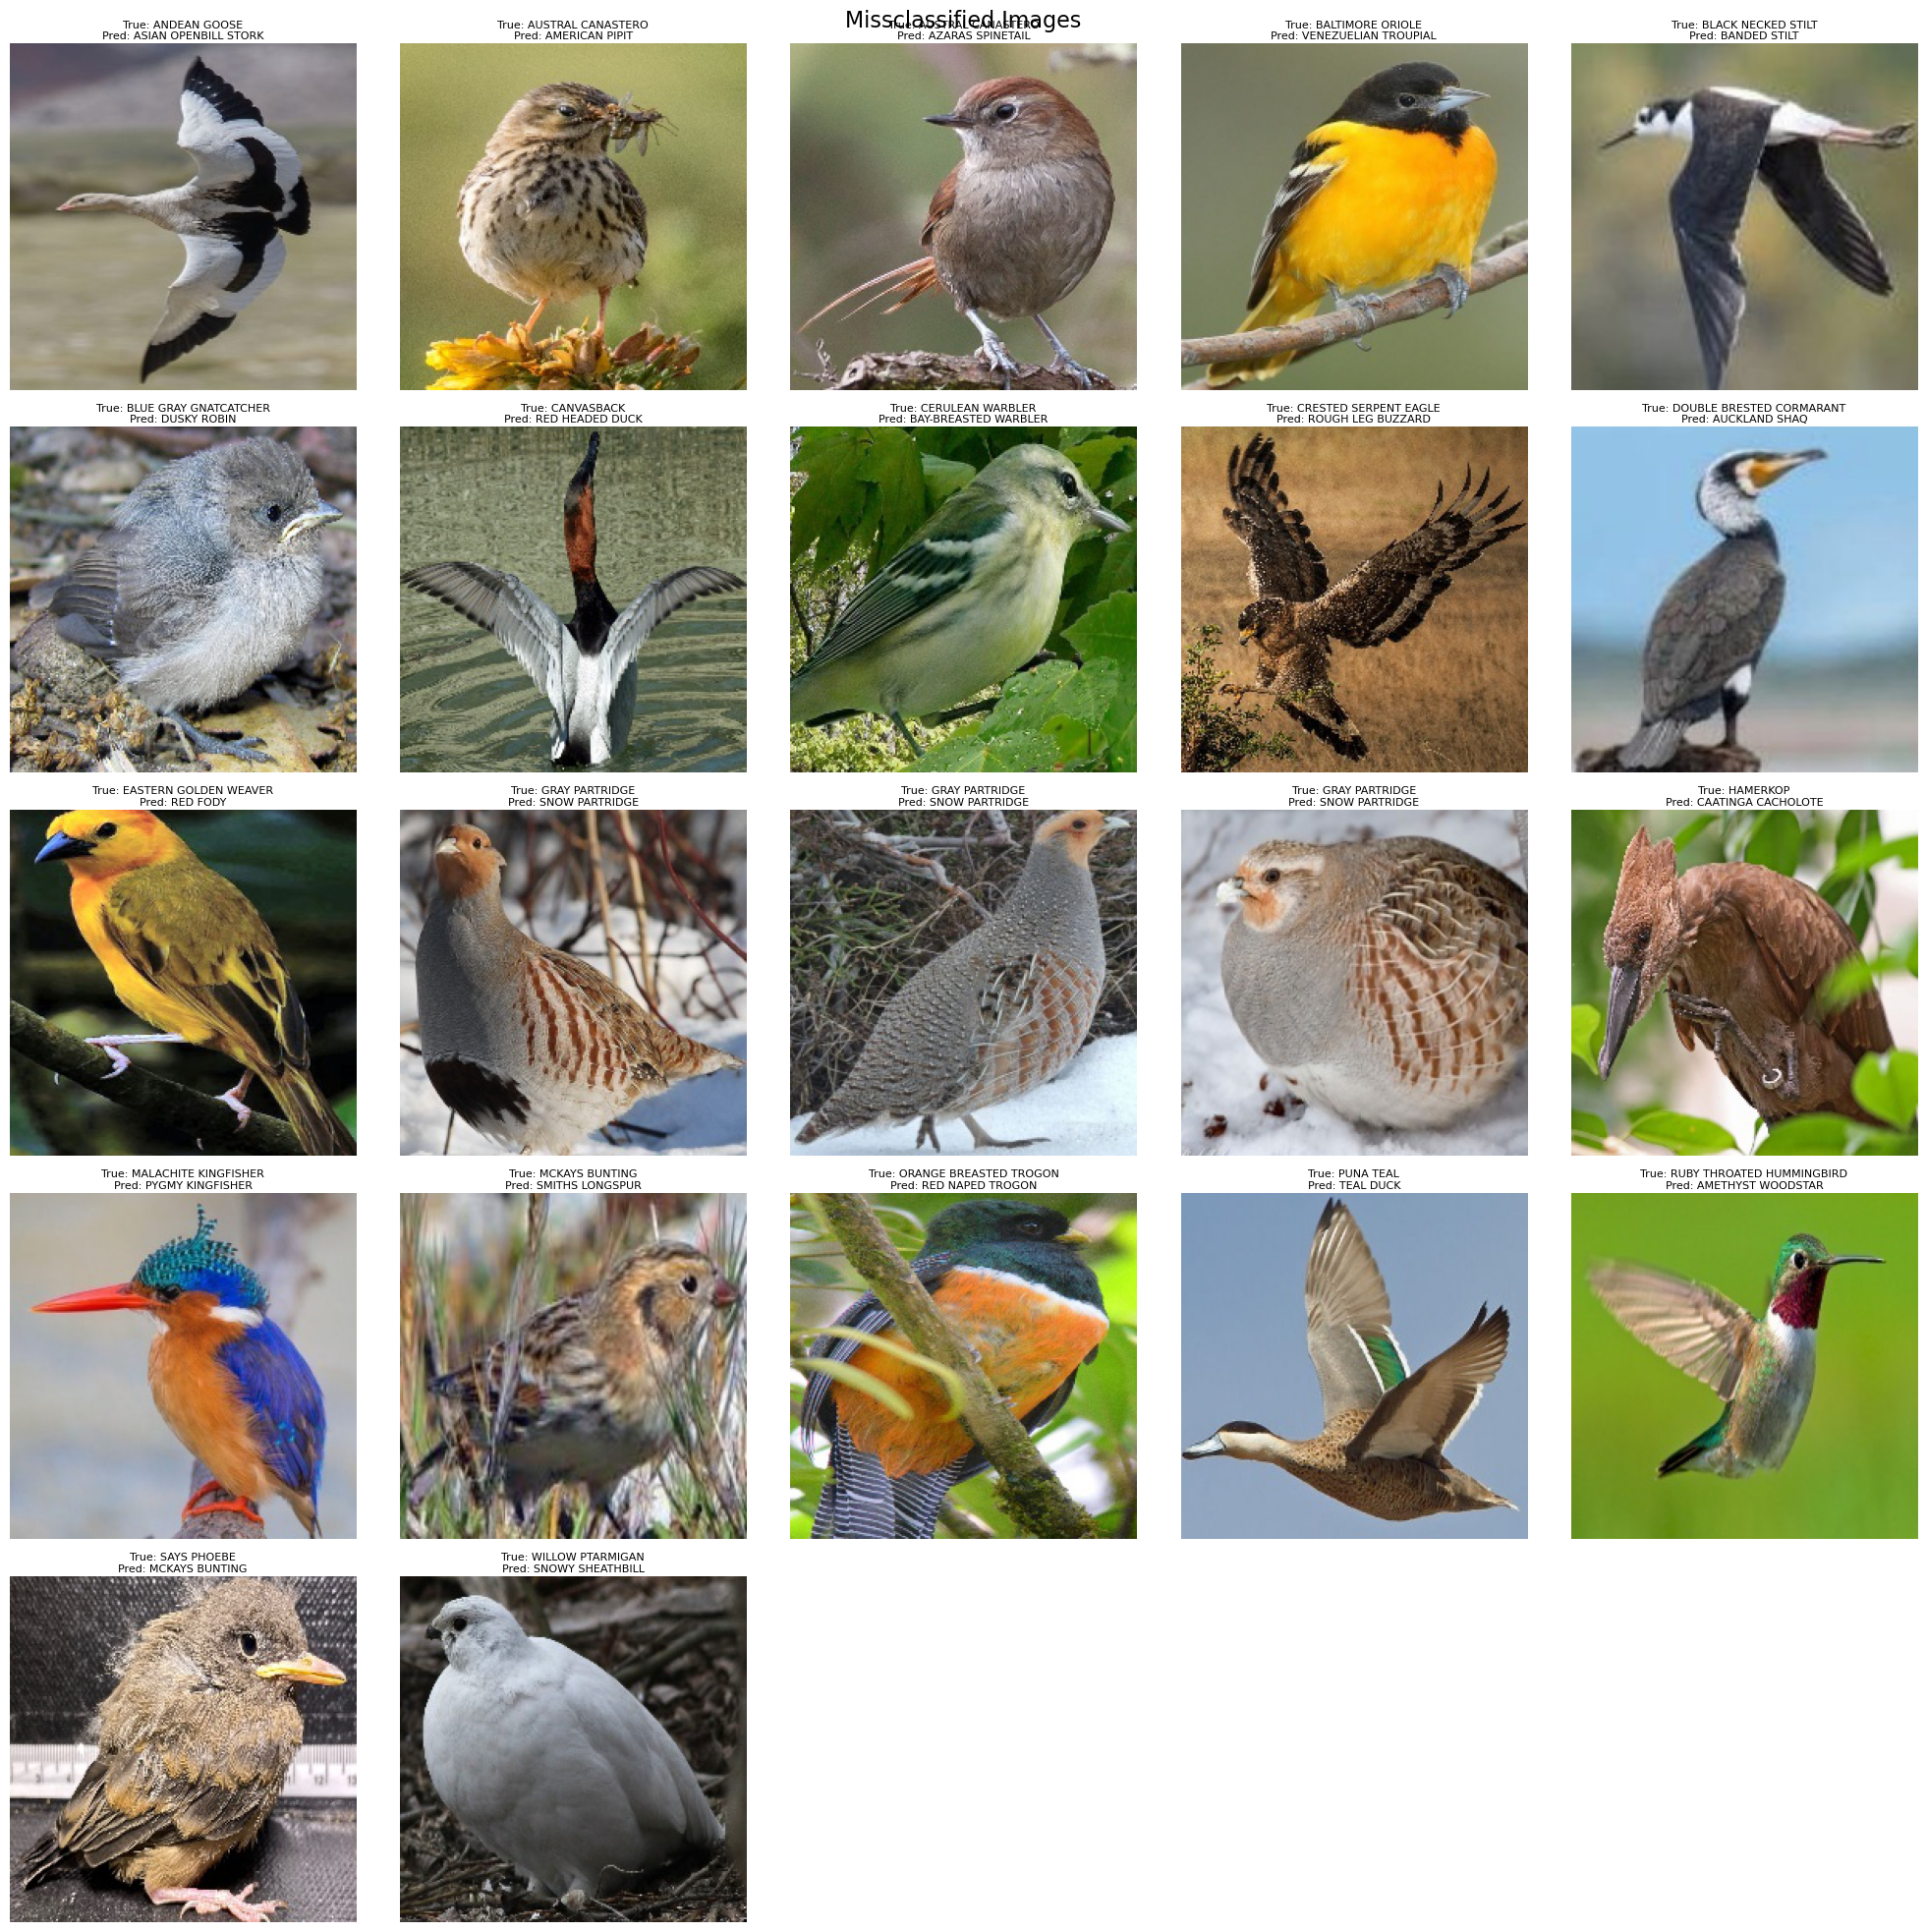

In [10]:
class_names = test_loader.dataset.classes

def visualize_images(incorrect_images, class_names, grid_size=5):
    
    pixel_values = np.array([i[0].cpu() for i in incorrect_images])
    labels = [i[1] for i in incorrect_images]
    predicted_labels =  [i[2] for i in incorrect_images]
    
    # Calculate how many images to display
    num_images = min(len(pixel_values), grid_size * grid_size)
    
    # Set up the figure size and grid layout
    plt.figure(figsize=(20, 20))
    plt.suptitle('Missclassified Images', fontsize=16)

    # Iterate over the images and labels up to num_images
    for i in range(num_images):
        img = pixel_values[i].cpu().numpy() # Convert tensor to numpy array
        img = np.transpose(img, (1, 2, 0))  # Rearrange the dimensions
        normalizer = Normalize(vmin=img.min(), vmax=img.max())
        img = normalizer(img)
        
        # Determine subplot position
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img)
        plt.axis('off')
        
        # Label the image with true and predicted classes
        true_class = class_names[labels[i]]
        pred_class = class_names[predicted_labels[i]]
        plt.title(f'True: {true_class}\nPred: {pred_class}', fontsize=8, pad=3)

    # Adjust layout to avoid overlap
    plt.tight_layout(pad=1.0)
    plt.show()

visualize_images(incorrect_samples, class_names)